## Import all relevant libraries and data

In [1]:
#conda install -c anaconda git


In [2]:
#conda install pydot

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import tensorflow_docs as tfdocs
from keras.optimizers import adam
from keras.utils import plot_model
from tensorflow import keras
from keras.models import Sequential, save_model, load_model
from keras.layers import LSTM,Dense, Dropout
from sklearn.preprocessing import MinMaxScaler


C:\Users\CZ\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\CZ\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\CZ\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\CZ\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1)

In [25]:
abl = pd.read_csv('ABL PA Equity.csv')
abl.head()

,Date,Open,High,Low,Close,Volume
0,2005-08-17 00:00:00,1.4809,7.2563,5.1831,6.2789,38266.0
1,2005-08-18 00:00:00,1.4809,7.2563,5.1831,6.2789,38266.0
2,2005-08-19 00:00:00,6.2789,6.2938,6.1086,6.2789,16582.0
3,2005-08-22 00:00:00,6.2789,6.4418,6.2567,6.3678,73980.0
4,2005-08-23 00:00:00,6.3678,6.3678,6.0494,6.3086,42092.0


## Data Visualization

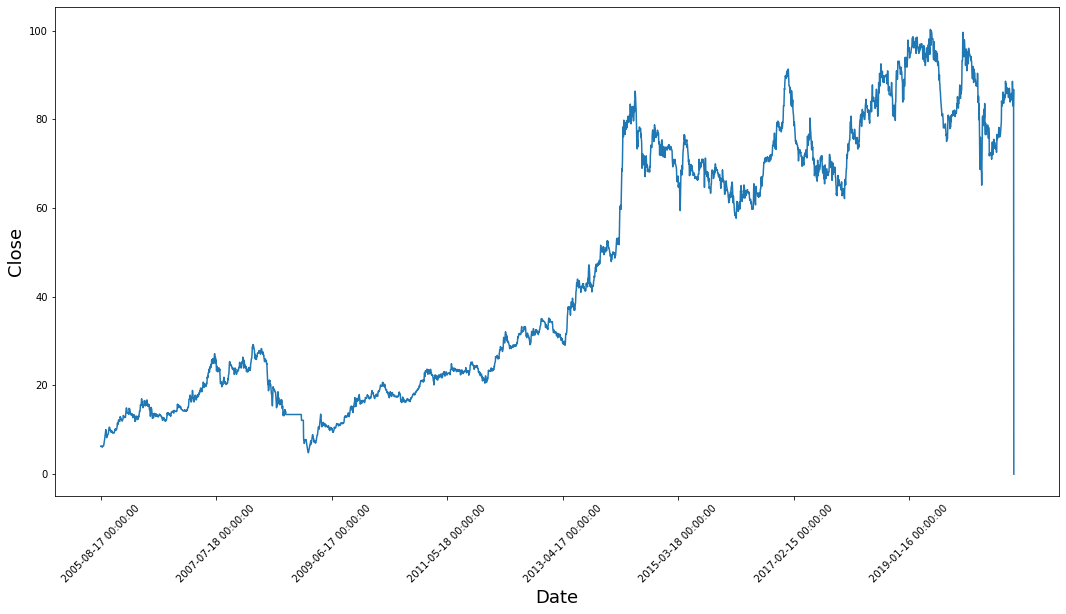

In [5]:
plt.figure(figsize = (18,9))
plt.plot(range(abl.shape[0]), abl['Close'])
plt.xticks(range(0, abl.shape[0], 500), abl['Date'].loc[::500], rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close', fontsize=18)
plt.show()

## Test-Train Split

In [6]:
def test_train_split(df):

    close_prices = df['Close'] #We choose to predict the close price

    # 80-10-10 split into Train-Validation-Test

    train_data = close_prices[:int(len(close_prices)*0.8)]
    #valid_data = close_prices[int(len(close_prices)*0.8):int(len(close_prices)*0.9)]
    test_data = close_prices[int(len(close_prices)*0.8):]

    train_data = np.asarray(train_data)
    #valid_data = np.asarray(valid_data)
    test_data = np.asarray(test_data)

    train_data = train_data.reshape(-1, 1)
    #valid_data = valid_data.reshape(-1, 1)
    test_data = test_data.reshape(-1, 1)


    print(train_data.shape[0])
    #print(valid_data.shape[0])
    print(test_data.shape[0])
    
    return train_data, test_data
    
train_data, test_data = test_train_split(abl)

3162
791


## Check distribution of data

{'whiskers': [<matplotlib.lines.Line2D at 0x1effa062c08>,
 'caps': [<matplotlib.lines.Line2D at 0x1effa07dd08>,
 'boxes': [<matplotlib.patches.PathPatch at 0x1effa07d748>],
 'medians': [<matplotlib.lines.Line2D at 0x1effa084fc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1effa089b88>],
 'means': []}

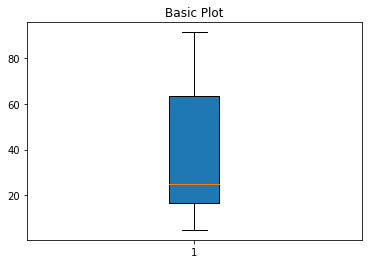

In [7]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(train_data, patch_artist=True)



## Prepare Train set

In [8]:
def train_prep(train_data):

    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_data)

    x_train = [] #Features
    y_train = [] #Labels

    for i in range(60, train_data.shape[0]): #Make windows of 60 days for training until last day

        x_train.append(train_data[i-60:i]) #60 day window
        y_train.append(train_data[i, 0]) #60th day price

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    print(x_train.shape, y_train.shape, scaler.scale_)
    
    return x_train, y_train, scaler.scale_
    
x_train, y_train, scale_train = train_prep(train_data)

(3102, 60, 1) (3102,) [0.01156523]


## Prepare test set

In [9]:
def test_prep(test_data, train_data):
    
    scaler = MinMaxScaler()
    test_data = np.concatenate((train_data[:60], test_data), axis = 0) #Add last 60 observations of train data to test
    test_data = scaler.fit_transform(test_data)

    x_test = []
    y_test = []

    for i in range(60, test_data.shape[0]):
        x_test.append(test_data[i-60:i])
        y_test.append(test_data[i, 0])

    x_test = np.array(x_test)
    y_test = np.array(y_test)
        
    print(x_test.shape, y_test.shape, scaler.scale_)
    return x_test, y_test, scaler.scale_
    
x_test, y_test, test_scale = test_prep(test_data, train_data)

(791, 60, 1) (791,) [0.00997343]


## Building the LSTM

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 64)            16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 115,841
Trainable params: 115,841
Non-trainable params: 0
_________________________________________________________________


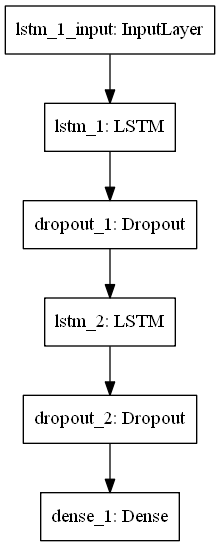

In [10]:
'''model = Sequential()
model.add(LSTM(units = 60, activation = 'relu', input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.summary()'''

model = Sequential()

model.add(LSTM(units = 64, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 128, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.summary()

plot_model(model, to_file='model.png')

In [11]:
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data = (x_test, y_test), verbose = 1)
filepath = 'E:/Fall 2020/Kaavish/Module 1/M1-LSTM-Pretrained'
model.save(filepath)





Train on 3102 samples, validate on 791 samples
Epoch 1/50
3102/3102 [==============================] - 16s 5ms/step - loss: 0.0168 - accuracy: 6.4475e-04 - val_loss: 0.0053 - val_accuracy: 0.0013
Epoch 2/50
3102/3102 [==============================] - 13s 4ms/step - loss: 0.0021 - accuracy: 6.4475e-04 - val_loss: 0.0057 - val_accuracy: 0.0013
Epoch 3/50
3102/3102 [==============================] - 13s 4ms/step - loss: 0.0021 - accuracy: 6.4475e-04 - val_loss: 0.0047 - val_accuracy: 0.0013
Epoch 4/50
3102/3102 [==============================] - 13s 4ms/step - loss: 0.0019 - accuracy: 6.4475e-04 - val_loss: 0.0064 - val_accuracy: 0.0013
Epoch 5/50
3102/3102 [==============================] - 13s 4ms/step - loss: 0.0019 - accuracy: 6.4475e-04 - val_loss: 0.0050 - val_accuracy: 0.0013
Epoch 6/50
3102/3102 [==============================] - 13s 4ms/step - loss: 0.0016 - accuracy: 6.4475e-04 - val_loss: 0.0041 - val_accuracy: 0.0013
Epoch 7/50
3102/3102 [==============================] - 13

OSError: Unable to create file (unable to open file: name = 'E:/Fall 2020/Kaavish/Module 1/M1-LSTM-Pretrained', errno = 13, error message = 'Permission denied', flags = 13, o_flags = 302)

In [12]:
filepath = 'E:/Fall 2020/Kaavish/Module 1/M1-LSTM-Pretrained'
#model = keras.models.load_model(filepath)
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['accuracy'])
evaluation = model.evaluate(x_test, y_test)
print(evaluation)

791/791 [==============================] - 1s 1ms/step
[0.003017839251260371, 0.0012642225483432412]


## Testing

In [21]:
x_test[-1]

array([[0.76496214],
       [0.76675736],
       [0.76376533],
       [0.77004859],
       [0.77982255],
       [0.78540767],
       [0.79328668],
       [0.83906473],
       [0.83178413],
       [0.82809396],
       [0.82809396],
       [0.83846633],
       [0.83786792],
       [0.85901159],
       [0.83736925],
       [0.84255543],
       [0.83387855],
       [0.84774162],
       [0.84794108],
       [0.8427549 ],
       [0.8427549 ],
       [0.85272833],
       [0.85272833],
       [0.84774162],
       [0.8834465 ],
       [0.87377227],
       [0.8764651 ],
       [0.8770635 ],
       [0.85562063],
       [0.86768848],
       [0.86938396],
       [0.85761531],
       [0.85761531],
       [0.86469645],
       [0.86649167],
       [0.85552089],
       [0.8567177 ],
       [0.84674427],
       [0.85771505],
       [0.85681744],
       [0.86669113],
       [0.86758874],
       [0.8602084 ],
       [0.85083338],
       [0.83667111],
       [0.84714321],
       [0.84445038],
       [0.846

In [13]:
y_hat = model.predict(x_test)


In [15]:
y_hat_unscaled = y_hat/test_scale[0]
y_test_unscaled = y_test/test_scale[0]


In [16]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test_unscaled, y_hat_unscaled)

30.339402745069336

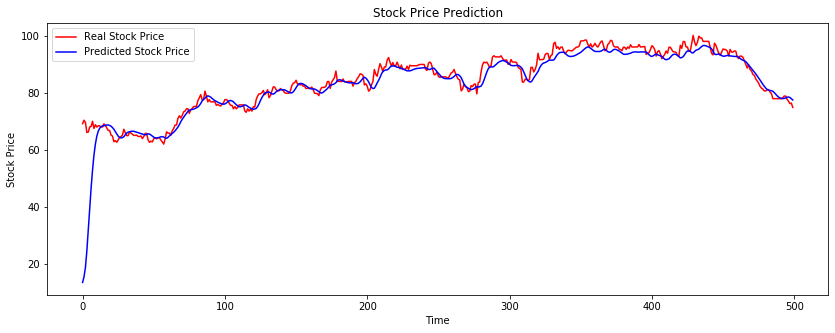

In [22]:
def plot_comparison(y_test, y_hat):

    plt.figure(figsize=(14,5))
    plt.plot(y_test[:500], color = 'red', label = 'Real Stock Price')
    plt.plot(y_hat[:500], color = 'blue', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
    
plot_comparison(y_test_unscaled, y_hat_unscaled)

In [19]:
print(model.predict(x_test[:60])/test_scale[0], x_test/test_scale[0])

[[13.622849]
 [15.573967]
 [18.84751 ]
 [24.725798]
 [32.065105]
 [39.64539 ]
 [46.808353]
 [53.037617]
 [58.324917]
 [62.155888]
 [64.91962 ]
 [66.6456  ]
 [67.691956]
 [68.268005]
 [68.50455 ]
 [68.56889 ]
 [68.721245]
 [68.8448  ]
 [68.844666]
 [68.66684 ]
 [68.41608 ]
 [67.9285  ]
 [67.34153 ]
 [66.5037  ]
 [65.70796 ]
 [64.95753 ]
 [64.45756 ]
 [64.303246]
 [64.41109 ]
 [64.72715 ]
 [65.40338 ]
 [66.00333 ]
 [66.33556 ]
 [66.45169 ]
 [66.58499 ]
 [66.643524]
 [66.61409 ]
 [66.47664 ]
 [66.30117 ]
 [66.1415  ]
 [65.95633 ]
 [65.784515]
 [65.674324]
 [65.48948 ]
 [65.394684]
 [65.50728 ]
 [65.72242 ]
 [65.66362 ]
 [65.34255 ]
 [64.95926 ]
 [64.54804 ]
 [64.327095]
 [64.3053  ]
 [64.355865]
 [64.5027  ]
 [64.67401 ]
 [64.729355]
 [64.60689 ]
 [64.29625 ]
 [64.16295 ]] [[[ 6.2789]
  [ 6.2789]
  [ 6.2789]
  ...
  [ 9.2555]
  [ 9.3296]
  [ 9.5665]]

 [[ 6.2789]
  [ 6.2789]
  [ 6.3678]
  ...
  [ 9.3296]
  [ 9.5665]
  [69.3087]]

 [[ 6.2789]
  [ 6.3678]
  [ 6.3086]
  ...
  [ 9.5665]
  [69

In [ ]:
def plot_accuracy(history):

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    '''plt.plot(history.history['mean_squared_error'], label='training data')
    plt.plot(history.history['val_mean_squared_error'], label='validation data')
    plt.title('Loss')
    plt.ylabel('MSE value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()'''
    
plot_accuracy(history)

## Predicting next day price

